# END TO END ML PROJECT (PREDICTION OF USED CAR PRICES) 

### Project Goal
The primary objective of this project is to develop a machine learning model that accurately predicts car prices based on various influencing factors. By leveraging historical data, the model aims to provide insights into how different attributes, such as engine size, mileage, brand, and transmission type, contribute to the pricing of vehicles. This predictive capability will assist stakeholders, including dealerships and potential buyers, in making informed decisions regarding car purchases and sales.

--------------------------------------

### Project Evaluation Metric : RMSE
The performance of the models will be assessed using Root Mean Squared Error (RMSE) as the primary evaluation metric. RMSE quantifies the average prediction error, providing a clear indication of how closely the model’s predictions align with actual prices.
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- **n** = total number of observations
- **y_i** = actual values
- **\hat{y}_i** = predicted values



 ## While doing this project I am going to apply some of the techniques below:
 * Cross Validation
 * Machine Learning
 * Hyperparameter Optimization (Optuna)
 * Data Preprocessing
 * Pipelines for Machine Learning Algorithms
 * Ensemble Models
 * Combining Models
 <a class="anchor"  id="chapter1"></a>
 
You can go to desired cell topic by clicking the links 
 
 * [Data Imports](#section-one)
  
* [Defining The Feature Engineering Functions](#section-two)
* [Pipeline Build](#chapter2)
* [Hyperparameter Optimization](#chapter3)
* [K-Fold Cross Validation for Ensemble Models](#chapter4)
* [Weighting Models](#chapter5)
* [K-Fold Cross Validation for Voting Regression](#chapter6)
* [Validation Scores for Multiple Metrics](#chapter7)
* [Test set scores!](#chapter8)
* [Conclusion](#chapter-nine)





### IMPORTS

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import re
import warnings
warnings.filterwarnings("ignore")

import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgbm
import sklearn.metrics as mt
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
import sklearn.metrics as mt


<a id="section-one"></a>

### DATA IMPORTS


In [98]:
train.shape[0]+test.shape[0]

253793

In [103]:
test_data.shape

(50759, 12)

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train = train_data.copy()
test = test_data.copy()

In [105]:
X_train.columns

Index(['publishDate', 'firstPublishedDate', 'state_code', 'zip', 'mileage',
       'make', 'body_type', 'vehicle_style', 'vehicle_trim', 'year',
       'listed_days_count', 'engine_size', 'door_count', 'cylinder_count',
       'transmission_type', 'car_age', 'transmission_type_2', 'age_segment'],
      dtype='object')

### SPLITTING DATA INTO TRAIN-TEST-VALIDATION FOR PREVENTING OURSELFS FROM DATA LEAKAGE.

In [4]:
X=train.drop(columns=["price"])
y=train["price"]
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.20,random_state=42)

<a id="section-two"></a>
### *Feature Engineering* 

In [5]:

def Feature_Engineering(df, current_year=2025):
    def extract_engine_size(vehicle_style):
        match = re.search(r'(\d+(\.\d+)?)[ ]?(L|Liter)', str(vehicle_style), re.IGNORECASE)
        return match.group(1) if match else np.NaN

    def extract_door_count(vehicle_style):
        match = re.search(r'(\d+(\.\d+)?)[ ]?(dr)', str(vehicle_style), re.IGNORECASE)
        return match.group(1) if match else np.NaN

    def extract_cylinders(vehicle_style):
        match = re.search(r'(\d+)[ ]?cyl', str(vehicle_style), re.IGNORECASE)
        return match.group(1) if match else np.NaN

    def extract_transmission(vehicle_style):
        match = re.search(r'(\d+AM|\d+[A|M]|CVT|DD)', str(vehicle_style), re.IGNORECASE)
        return match.group(1) if match else np.NaN

    df['engine_size'] = df['vehicle_style'].apply(extract_engine_size)
    df['door_count'] = df['vehicle_style'].apply(extract_door_count)
    df['cylinder_count'] = df['vehicle_style'].apply(extract_cylinders)
    df['transmission_type'] = df['vehicle_style'].apply(extract_transmission)

    
    df.loc[(df["vehicle_style"].str.contains("electric", na=False)) & (df["cylinder_count"].isna()), "engine_size"] = "Electric"
    df.loc[(df["vehicle_style"].str.contains("electric", na=False)) & (df["cylinder_count"].isna()), "cylinder_count"] = "Electric"

    df.loc[(df["engine_size"].isna()) & ((df["vehicle_style"].str.contains("fuel", na=False)) |
                                         (df["vehicle_style"].str.contains("CVT", na=False))),
           "engine_size"] = "engine_size_unknown_fuel_car"

    df.loc[(df["cylinder_count"].isna()) & ((df["vehicle_style"].str.contains("fuel", na=False)) |
                                            (df["vehicle_style"].str.contains("CVT", na=False))),
           "cylinder_count"] = "cylinder_count_unknown_fuel_car"

    df["car_age"] = current_year - df["year"]

    df.loc[(df["transmission_type"].isna()) & (df["vehicle_style"].str.contains("gas/electric", na=False)), "transmission_type"] = "hybrid"

    transmission_mapping = {
        # Automatic
        '8A': 'automatic', '6A': 'automatic', '9A': 'automatic', '10A': 'automatic',
        '5A': 'automatic', '4A': 'automatic', '7A': 'automatic', '3A': 'automatic',
        '2A': 'electric',  # Special case, marked as electric in the example
        # Automated Manual
        '7AM': 'automated-manual', '8AM': 'automated-manual', '6AM': 'automated-manual',
        '5AM': 'automated-manual', '9AM': 'automated-manual',
        # Manual
        '6M': 'manual', '4M': 'manual', '7M': 'manual', '5M': 'manual',
        # Electric
        'DD': 'electric', 'dd': 'electric',
        # Hybrid
        'hybrid': 'hybrid',
        # CVT
        "CVT": "CVT"
    }

    df['transmission_type_2'] = df['transmission_type'].map(transmission_mapping)

    bins = [0, 4, 9, 15, 22, 30, 60] 
    labels = [0, 1, 2, 3, 4, 5]  
    df['age_segment'] = pd.cut(df['car_age'], bins=bins, labels=labels, right=True, include_lowest=True)

    return df

In [6]:
X_train = Feature_Engineering(X_train)
X_val = Feature_Engineering(X_val)

In [7]:
X_train.head(1)

,publishDate,firstPublishedDate,state_code,zip,mileage,make,body_type,vehicle_style,vehicle_trim,year,listed_days_count,engine_size,door_count,cylinder_count,transmission_type,car_age,transmission_type_2,age_segment
113556,2024-08-08 22:23:49.351,2024-06-21 12:30:10,CA,91733,25921.0,Mercedes-Benz,Coupe,R 2dr Coupe (4.0L 8cyl Turbo 7AM),R,2020,49,4.0,2,8,7AM,5,automated-manual,1


<a id="chapter2"></a>

### *Building The Pipeline* 

In [8]:
target = 'price'
numeric_features = ["year","listed_days_count","door_count","car_age"]
categorical_features = ["state_code","zip","make","body_type","vehicle_style","vehicle_trim","engine_size","cylinder_count","transmission_type",
                        "transmission_type_2","age_segment"]

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

<a id="chapter3"></a>
### *Hyperparameter Optimization with Optuna Library*

#### XGBOOST OPTUNA
Best RMSE : 8117.3553253543905  

* parameters: {'max_depth': 15, 'learning_rate': 0.05296660283065631, 'n_estimators': 126, 'min_child_weight': 10, 'subsample': 0.9893631526916168, 'colsample_bytree': 0.5124428472442656, 'gamma': 1.316880000486226e-08, 'reg_alpha': 0.5298860553217419, 'reg_lambda': 4.136887971660181e-06}

In [55]:
# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 2, 15),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 600),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),}

#     model =xgb.XGBRegressor(**params)
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('model', model)])

#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_val)
#     rmse = mt.mean_squared_error(y_val, predictions,squared=False)
#     return rmse
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100,timeout=600)

### LIGHTGBM OPTUNA
Best RMSE score: 7886.356337876714

- Best trial parameters:
 {'max_depth': 10, 'learning_rate': 0.13041244380537204, 'n_estimators': 598, 'min_child_weight': 7, 'subsample': 0.6557583384866239, 'colsample_bytree': 0.5917814788649068, 'reg_alpha': 1.155243040648194e-08, 'reg_lambda': 0.03998522636161519, 'num_leaves': 137, 'min_child_samples': 40, 'feature_fraction': 0.5020194969680079}


In [51]:
# #I normally use pipeline structure, since I use early stopping I did not use pipeline to get best params but in the other codes I used pipeline structure
# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 2, 15),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 600),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # LightGBM specific
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # LightGBM specific
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
#         "verbose":0# LightGBM specific
#     }

#     model = lgbm.LGBMRegressor(**params)

#     # Transform the training and validation data
#     X_train_transformed = preprocessor.fit_transform(X_train)
#     X_val_transformed = preprocessor.transform(X_val)

#     # Train the model with early stopping
#     model.fit(X_train_transformed, y_train,
#               eval_set=[(X_val_transformed, y_val)],  # Validation set
#               eval_metric='rmse',                    # Evaluation metric
# callbacks=(
#             [lgbm.early_stopping(stopping_rounds=100)]))

#     # Make predictions
#     predictions = model.predict(X_val_transformed)
    
#     # Calculate RMSE
#     rmse = mt.mean_squared_error(y_val, predictions, squared=False)
#     return rmse

# # Create and optimize the study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=300)

# # Output the best parameters and value
# print("Best trial parameters:", study.best_params)
# print("Best RMSE score:", study.best_value)


In [59]:
# import optuna
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# import numpy as np
# from sklearn.metrics import mean_squared_error as mt

# def objective(trial):
#     params = {
#         'depth': trial.suggest_int('depth', 2, 15),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'iterations': trial.suggest_int('iterations', 100, 600),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 1.0),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#     #    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'random_strength': trial.suggest_uniform('random_strength', 0, 10),
#         'border_count': trial.suggest_int('border_count', 1, 255),    }

#     model = CatBoostRegressor(**params, verbose=0)  # Disable CatBoost's verbose output
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                 ('model', model)])

#     pipeline.fit(X_train, y_train)
#     predictions = pipeline.predict(X_val)
#     rmse = mt(y_val, predictions, squared=False)  # Calculate RMSE
#     return rmse

# # Create a study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=300)


In [9]:
# cb_params = {'depth': 10, 'learning_rate': 0.06545528849901149, 'iterations': 454, 'l2_leaf_reg': 5.627334494455288, 'subsample': 0.907860006008691, 'rsm': 0.6121219607102849, 'random_strength': 0.00599273019294434, 'bagging_temperature': 0.00012917747774166064, 'border_count': 96}
# model_cat = cat.CatBoostRegressor(**cb_params)
# pipeline_cbr = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('model', model_cat)])
best_params={'max_depth': 10, 'learning_rate': 0.13041244380537204, 'n_estimators': 598, 'min_child_weight': 7, 'subsample': 0.6557583384866239, 'colsample_bytree': 0.5917814788649068, 'reg_alpha': 1.155243040648194e-08, 'reg_lambda': 0.03998522636161519, 'num_leaves': 137, 'min_child_samples': 40, 'feature_fraction': 0.5020194969680079}
model = lgbm.LGBMRegressor(**best_params)
pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
xgb_params = {'max_depth': 15, 'learning_rate': 0.05296660283065631, 'n_estimators': 126, 'min_child_weight': 10, 'subsample': 0.9893631526916168, 'colsample_bytree': 0.5124428472442656, 'gamma': 1.316880000486226e-08, 'reg_alpha': 0.5298860553217419, 'reg_lambda': 4.136887971660181e-06}
xgb_model = xgb.XGBRegressor(**xgb_params)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', xgb_model)])

In [11]:
# pipeline_cbr.fit(X_train,y_train)
pipeline_xgb.fit(X_train,y_train)
pipeline_lgbm.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 162427, number of used features: 15
[LightGBM] [Info] Start training from score 27773.332402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['year', 'listed_days_count',
                                                   'door_count', 'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['state_c...
                                                   'transmission_type_2',
                                                   'age_segment'])])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.5917814788649068,
                               feature_fraction=0.5020194969680079,
                               learning_rate=0.13041244380537204, max_depth=10,
                               min_child_samples=40, min_child_weight=7,
                               n_estimators=598, num_leaves=137,
                               reg_alpha=1.155243040648194e-08,
                               reg_lambda=0.03998522636161519,
                               subsample=0.6557583384866239))])

<a id="section-one"></a>
## K-Fold Cross Validation for Each Ensemble Model

In [63]:
skf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=skf,
                            scoring="neg_root_mean_squared_error")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {-score :.5f}")

print("---" * 8)
print(f"Mean RMSE Score : {-cv_scores.mean() :.5f}")
print(f"Standard Deviation for RMSE Scores: {cv_scores.std() :.5f}")

Fold 1 score: 6887.63359
Fold 2 score: 14550.60856
Fold 3 score: 9361.54851
Fold 4 score: 7825.00157
Fold 5 score: 6581.76698
------------------------
Mean RMSE Score : 9041.31184
Standard Deviation for RMSE Scores: 2919.65763


In [70]:
# from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
# skf = KFold(n_splits=5, shuffle=True, random_state=42)

# cv_scores = cross_val_score(pipeline_lgbm, X_train, y_train, cv=skf,
#                             scoring="neg_root_mean_squared_error")

# for i, score in enumerate(cv_scores):
#     print(f"Fold {i + 1} score: {-score :.5f}")

# print("---" * 8)
# print(f"Mean RMSE Score : {-cv_scores.mean() :.5f}")
# print(f"Standard Deviation for RMSE Scores: {cv_scores.std() :.5f}")

"""
Fold 1 score: 7184.39125
Fold 2 score: 14577.01629
Fold 3 score: 9132.34840
Fold 4 score: 7927.16439
Fold 5 score: 6937.10019
------------------------
Mean RMSE Score : 9151.60410
Standard Deviation for RMSE Scores: 2818.10840"""

'\nFold 1 score: 7184.39125\nFold 2 score: 14577.01629\nFold 3 score: 9132.34840\nFold 4 score: 7927.16439\nFold 5 score: 6937.10019\n------------------------\nMean RMSE Score : 9151.60410\nStandard Deviation for RMSE Scores: 2818.10840'

In [12]:
# cb_preds=pipeline_cbr.predict(X_val)
lgb_preds=pipeline_lgbm.predict(X_val)
xgb_preds=pipeline_xgb.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079


In [13]:
def objective(trial):
    w1 = trial.suggest_float("w1", 0, 1)
    w2 = 1 - w1  # Calculate w2 to ensure w1 + w2 = 1
   # w3 = 1 - (w1 + w2)
    
    y_pred = np.average([ #cb_preds,
                         lgb_preds, xgb_preds], axis=0, 
    weights=[w1, w2,
             #w3 
             ])
    
    rmse = mt.mean_squared_error(y_val, y_pred, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_weights = study.best_params
print(best_weights)

[I 2024-09-28 13:07:07,154] A new study created in memory with name: no-name-4e459377-584f-425e-801d-f5b731ad2492
[I 2024-09-28 13:07:07,158] Trial 0 finished with value: 8051.111969582472 and parameters: {'w1': 0.0700740025549692}. Best is trial 0 with value: 8051.111969582472.
[I 2024-09-28 13:07:07,158] Trial 1 finished with value: 7977.465191820223 and parameters: {'w1': 0.1589875604949278}. Best is trial 1 with value: 7977.465191820223.
[I 2024-09-28 13:07:07,170] Trial 2 finished with value: 8065.631717470017 and parameters: {'w1': 0.054047954529917064}. Best is trial 1 with value: 7977.465191820223.
[I 2024-09-28 13:07:07,177] Trial 3 finished with value: 7814.318455579544 and parameters: {'w1': 0.8058253533213311}. Best is trial 3 with value: 7814.318455579544.
[I 2024-09-28 13:07:07,177] Trial 4 finished with value: 8053.100443572269 and parameters: {'w1': 0.06785443944751535}. Best is trial 3 with value: 7814.318455579544.
[I 2024-09-28 13:07:07,185] Trial 5 finished with val

{'w1': 0.6392243670705877}


In [14]:
w1=best_weights["w1"]
w2=1-w1
print("w1",w1)
print("w2",w2)


w1 0.6392243670705877
w2 0.3607756329294123


<a id="chapter6"></a>
### K-Fold Cross Validation Score for VotingRegressor with Best Weights

In [88]:

voting_reg = VotingRegressor(
    estimators=[('xgb', xgb.XGBRegressor(**xgb_params)), ('lgb', lgbm.LGBMRegressor(**best_params,verbose=0)),
                #("cb",cat.CatBoostRegressor(**cb_params))
                 ],
    weights=[w2, w1]  
)  
pipeline_vote = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', voting_reg)])
skf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline_vote, X_train, y_train, cv=skf,
                            scoring="neg_root_mean_squared_error")

for i, score in enumerate(cv_scores):
    print(f"Fold {i + 1} score: {-score :.2f}")

print("---" * 8)
print(f"Mean RMSE : {-cv_scores.mean() :.2f}")
print(f"Standard Deviation: {cv_scores.std() :.2f}")
"""
Fold 1 score: 6896.20
Fold 2 score: 14491.17
Fold 3 score: 9066.90
Fold 4 score: 7727.58
Fold 5 score: 6424.45
------------------------
Mean RMSE : 8921.26
Standard Deviation: 2925.92
"""

'\nFold 1 score: 6896.20\nFold 2 score: 14491.17\nFold 3 score: 9066.90\nFold 4 score: 7727.58\nFold 5 score: 6424.45\n------------------------\nMean RMSE : 8921.26\nStandard Deviation: 2925.92\n'

In [15]:
voting_reg = VotingRegressor(
    estimators=[('xgb', xgb.XGBRegressor(**xgb_params)), ('lgb', lgbm.LGBMRegressor(**best_params,verbose=0)),
                #("cb",cat.CatBoostRegressor(**cb_params))
                 ],
    weights=[w2, w1]  
)  
pipeline_vote = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', voting_reg)])
pipeline_vote.fit(X_train,y_train)


[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['year', 'listed_days_count',
                                                   'door_count', 'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['state_c...
                                              LGBMRegressor(colsample_bytree=0.5917814788649068,
                                                            feature_fraction=0.5020194969680079,
                                                            learning_rate=0.13041244380537204,
                                                            max_depth=10,
                                                            min_child_samples=40,
                                                            min_child_weight=7,
                                                            n_estimators=598,
                                                            num_leaves=137,
                                                            reg_alpha=1.155243040648194e-08,
                                                            reg_lambda=0.03998522636161519,
                                                            subsample=0.6557583384866239,
                                                            verbose=0))],
                                 weights=[0.3607756329294123,
                                          0.6392243670705877]))])

<a id="chapter7"></a>

### Validation Scores for Multiple Metrics

In [14]:
predictions = pipeline_vote.predict(X_val)
print("Model Scores for Validation")
print("-"*45)
print("-"*45)
print("R^2 Score for Validation Set",mt.r2_score(y_true=y_val,y_pred=predictions))
print("-"*45)
print("RMSE Score for Validation Set",mt.mean_squared_error(y_true=y_val,y_pred=predictions,squared=False))
print("-"*45)
print("MAE Score for Validation Set",mt.mean_absolute_error(y_true=y_val,y_pred=predictions))
print("-"*45)
print("Median Absolute Error Score for Validation Set",mt.median_absolute_error(y_true=y_val,y_pred=predictions))

[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
Model Scores for Validation
---------------------------------------------
---------------------------------------------
R^2 Score for Validation Set 0.8952078682316607
---------------------------------------------
RMSE Score for Validation Set 7792.082852993299
---------------------------------------------
MAE Score for Validation Set 3019.0294357420075
---------------------------------------------
Median Absolute Error Score for Validation Set 1872.755218064016


In [21]:
test_transformed=Feature_Engineering(test)

### Combining Train and Validation set for better model


In [18]:
X_train_combined = pd.concat([X_train,X_val])
y_train_combined = pd.concat([y_train,y_val])
pipeline_vote.fit(X_train_combined,y_train_combined)

[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['year', 'listed_days_count',
                                                   'door_count', 'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['state_c...
                                              LGBMRegressor(colsample_bytree=0.5917814788649068,
                                                            feature_fraction=0.5020194969680079,
                                                            learning_rate=0.13041244380537204,
                                                            max_depth=10,
                                                            min_child_samples=40,
                                                            min_child_weight=7,
                                                            n_estimators=598,
                                                            num_leaves=137,
                                                            reg_alpha=1.155243040648194e-08,
                                                            reg_lambda=0.03998522636161519,
                                                            subsample=0.6557583384866239,
                                                            verbose=0))],
                                 weights=[0.3607756329294123,
                                          0.6392243670705877]))])

<a id="chapter8"></a>
## Test Set Values

In [22]:
t_pred = pipeline_vote.predict(test_transformed.drop(columns=["price"]))
print("Model Scores for Test Set")
print("-"*45)
print("-"*45)
print("R^2 Score for Test Set",mt.r2_score(y_true=test_transformed["price"],y_pred=t_pred))
print("-"*45)
print("RMSE Score for Test Set",mt.mean_squared_error(y_true=test_transformed["price"],y_pred=t_pred,squared=False))
print("-"*45)
print("MAE Score for Test Set",mt.mean_absolute_error(y_true=test_transformed["price"],y_pred=t_pred))
print("-"*45)
print("Median Absolute Error Score for Test Set",mt.median_absolute_error(y_true=test_transformed["price"],y_pred=t_pred))

[LightGBM] [Warning] feature_fraction is set=0.5020194969680079, colsample_bytree=0.5917814788649068 will be ignored. Current value: feature_fraction=0.5020194969680079
Model Scores for Test Set
---------------------------------------------
---------------------------------------------
R^2 Score for Test Set 0.9230038976954823
---------------------------------------------
RMSE Score for Test Set 6279.972515530337
---------------------------------------------
MAE Score for Test Set 2953.331178275504
---------------------------------------------
Median Absolute Error Score for Test Set 1840.6605611822815


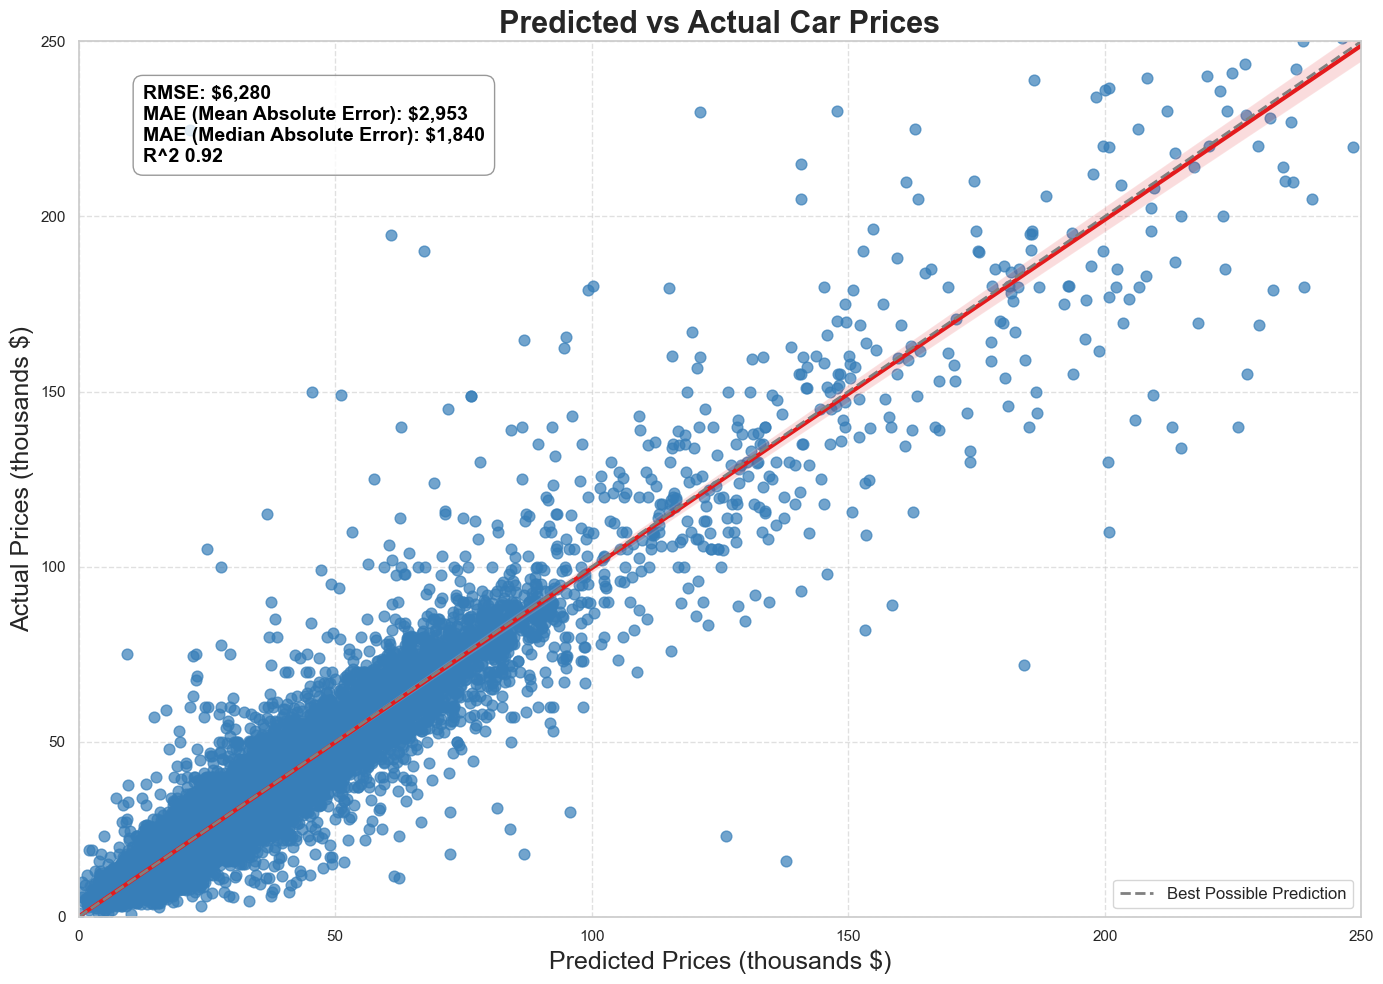

In [124]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 10))

sns.regplot(
    x=t_pred, 
    y=test_transformed["price"], 
    scatter_kws={'s': 60, 'color': '#377eb8', 'alpha': 0.7},
    line_kws={'color': '#e41a1c', 'linewidth': 3}
)

plt.xlim(0, 250000)
plt.ylim(0, 250000)

plt.xticks(range(0, 251000, 50000))
plt.yticks(range(0, 251000, 50000))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x/1000), ',')))

plt.title("Predicted vs Actual Car Prices", fontsize=22, fontweight='bold')
plt.xlabel("Predicted Prices (thousands $)", fontsize=18)
plt.ylabel("Actual Prices (thousands $)", fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)

diagonal = np.linspace(*plt.gca().get_xlim())
plt.plot(diagonal, diagonal, '--', color='gray', linewidth=2, label='Best Possible Prediction')

rmse_value = 6280
mae_value = 2953
median_abs = 1840
r2_score = 0.92
metrics_text = (
    f'RMSE: ${rmse_value:,}\n'
    f'MAE (Mean Absolute Error): ${mae_value:,}\n'
    f'MAE (Median Absolute Error): ${median_abs:,}\n'
    f"R^2 {r2_score}"
)

plt.text(
    0.05, 0.95, metrics_text, 
    fontsize=14, color='black', fontweight='bold', 
    transform=plt.gca().transAxes, 
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.5'),
    verticalalignment='top'
)

plt.legend(fontsize=12, loc='lower right')

plt.tight_layout()

plt.show()

<a id="chapter-nine"></a>
# Conclusion

* We managed to reach 0.92 R^2 Score which means we can understand 92% of the Variation in the Car Prices based on the Features we have.
------------------------------------------------------------------------------------------------------------------------------------
* RMSE Score: $6281 Interpretation: On average, our predictions may deviate by about $6,280 from the actual price.

* IMPORTANT: While this figure(RMSE) might seem high, it's important to consider the wide range of car prices in the market. For luxury or high-end vehicles, this error margin represents a smaller percentage of the total price.Because of this Situation We will take a look at two extra metrics.
----------------------------------------------------------------------------------------
* MAE(Mean Absolute Error) Score is showing that most price predictions are off by approximately +- $2953 from the actual values.
* Significance: This lower figure compared to RMSE suggests that extreme errors are less common, and most predictions fall closer to the actual price.
----------------------------------------------------------------------------------------
* Median Absolute Error: $1,841

* Interpretation: Half of our predictions are within $1,841 of the actual price.
* IMPORTANT: This metric is less affected by outliers and indicates that a majority of our predictions are quite close to the actual prices.

----------------------------------------------------------

###  Key Project Achievements:
Data-Driven Insights: The model effectively identifies how specific car attributes influence the price. For instance, factors like engine size, car brand, mileage, and transmission type are critical determinants of vehicle value.

Cross-Validation: By using K-Fold Cross-Validation, we ensured the model’s performance was evaluated across multiple subsets of the data, reducing the risk of overfitting and improving generalizability.

Ensemble Methods & Voting Regressors: We combined the strengths of several machine learning algorithms using ensemble techniques and Voting Regressors. This approach boosted the model’s predictive power, making it more robust and reliable for real-world applications.

Hyperparameter Tuning with Optuna: Using Optuna for hyperparameter optimization allowed us to fine-tune model parameters, leading to better overall performance. This method efficiently explored various hyperparameter combinations, ensuring we achieve optimal results without unnecessary computation.